<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, MeanShift
from sklearn.preprocessing import MinMaxScaler
import psycopg2
from random import choice
import contextily as ctx
import numpy as np
from shapely.geometry import Point, LineString, shape
from tqdm import tqdm_notebook
import numpy as np
from multiprocessing import cpu_count, Pool
from functools import partial
import datetime
from lonelyboy.geospatial import plots as gsplt
from lonelyboy.geospatial import preprocessing as gspp
from lonelyboy.timeseries import lbtimeseries as tspp
import configparser, os

In [2]:
properties = configparser.ConfigParser()
# properties.read(os.path.join('.','sql_server.ini'))
# properties = properties['SERVER']

# host    = properties['host']
# db_name = properties['db_name']
# uname   = properties['uname']
# pw      = properties['pw']
# port    = properties['port']

host    = '195.251.230.8'
db_name = 'doi105281zenodo1167595'
uname   = 'students'
pw      = 'infol@bdbl@bs2017'
port    = '46132'

# ts>1456802710 AND ts<1456975510 

traj_sql = 'SELECT * FROM ais_data.dynamic_ships WHERE  mmsi=226179000'
ports_sql = 'SELECT * FROM ports.ports_of_brittany'

con = psycopg2.connect(database=db_name, user=uname, password=pw, host=host, port = port)
traj = gpd.GeoDataFrame.from_postgis(traj_sql, con, geom_col='geom' )
ports = gpd.GeoDataFrame.from_postgis(ports_sql, con, geom_col='geom' )

con.close()


ports.geom = ports.geom.apply(lambda x: x[0])

In [3]:
fsize = (20,10)

In [4]:
# traj = pd.read_csv('data/updated_ais.csv', index_col=0)
# traj.geom = traj[['lon', 'lat']].apply(lambda x: Point(x[0],x[1]), axis=1)
# traj = gpd.GeoDataFrame(traj, geometry='geom')
# traj.drop_duplicates(['ts','mmsi'], inplace=True)

In [6]:
sample_ves = traj.loc[traj.mmsi == 226179000]
sample_ves.drop_duplicates(['ts'], inplace=True)
clean_sv = sample_ves.drop(gspp.get_outliers(sample_ves.ts, alpha=3)[0], axis=0)
print (len(sample_ves)- len(clean_sv))
clean_sv.sort_values(['ts'], inplace=True)
clean_sv.reset_index(inplace=True)
clean_sv.drop(['index','id', 'status'], axis=1, inplace=True)

0


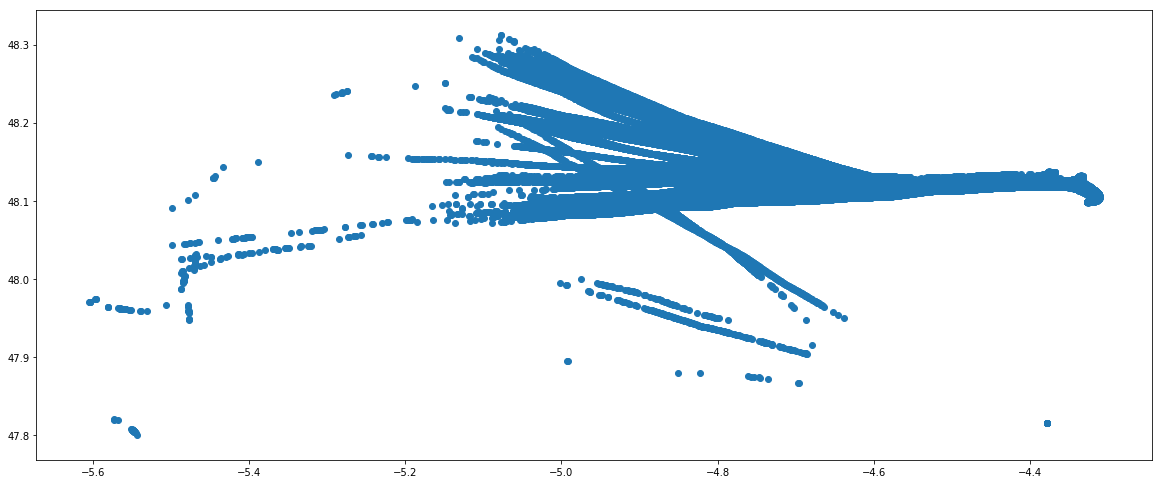

In [7]:
clean_sv.plot(figsize=fsize)

In [22]:
tmp = gspp.calculate_velocity(clean_sv, smoothing=True, window=3)

/home/theo/Code/lonelyboy/geospatial/preprocessing.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  gdf['next_loc'] = gdf.next_loc.apply(lambda x : (x.x,x.y))
/home/theo/Code/lonelyboy/geospatial/preprocessing.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  gdf['velocity'] = gdf[['current_loc', 'next_loc']].apply(lambda x : haversine(x[0], x[1])*0.539956803 , axis=1).multiply(3600/gdf.ts.diff(-1).abs())
/home/theo/Code/lonelyboy/geospatial/preprocessing.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [23]:
tmp = tmp.drop(gspp.get_outliers(tmp.velocity, alpha=3)[0], axis=0)

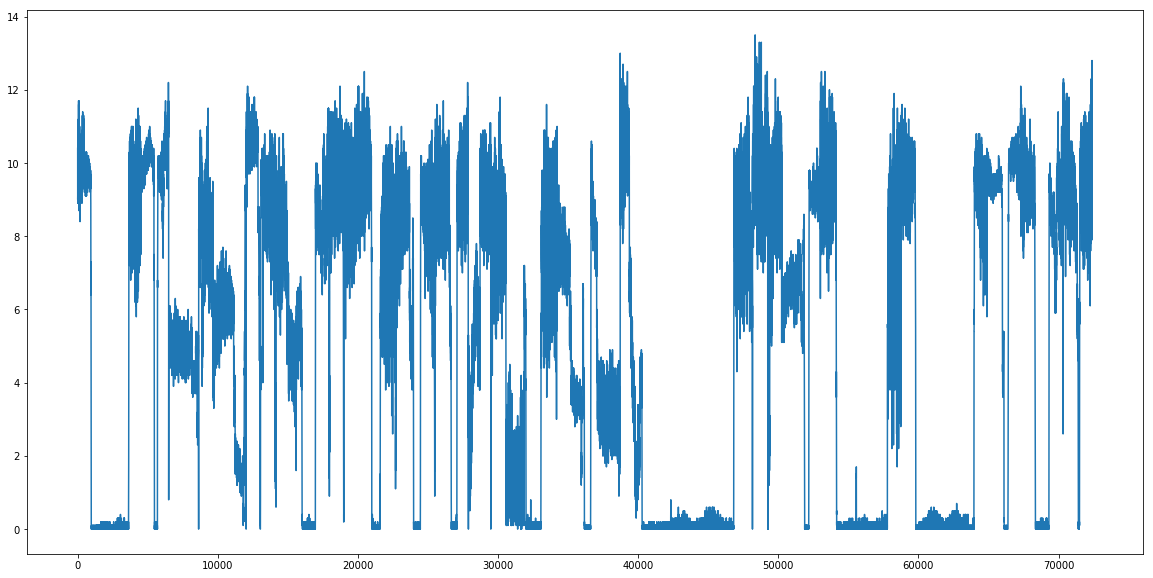

In [24]:
tmp.speed.plot(figsize=fsize)

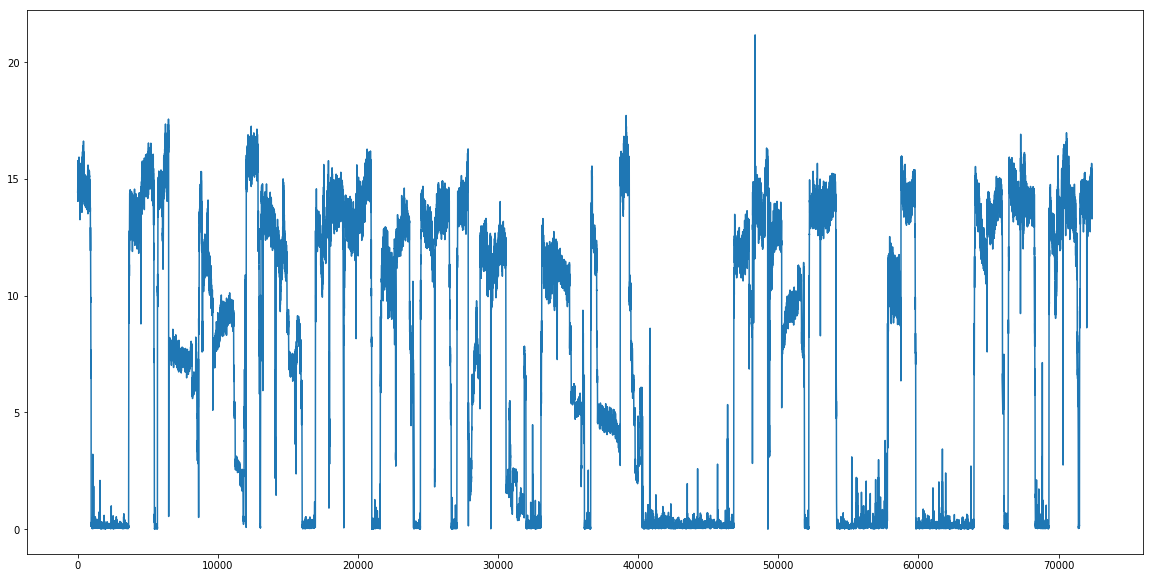

In [25]:
tmp.velocity.plot(figsize=fsize)

In [26]:
tmp = gspp.resample_geospatial(tmp)

In [27]:
tmp = tmp.drop(gspp.get_outliers(tmp.velocity, alpha=3)[0], axis=0)

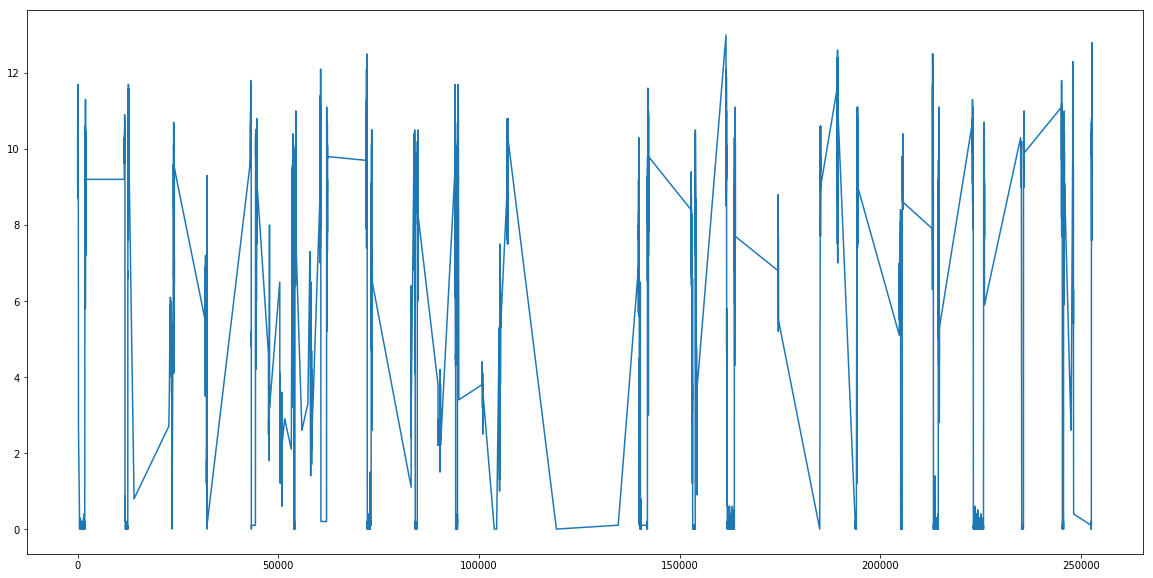

In [28]:
tmp.speed.plot(figsize=fsize)

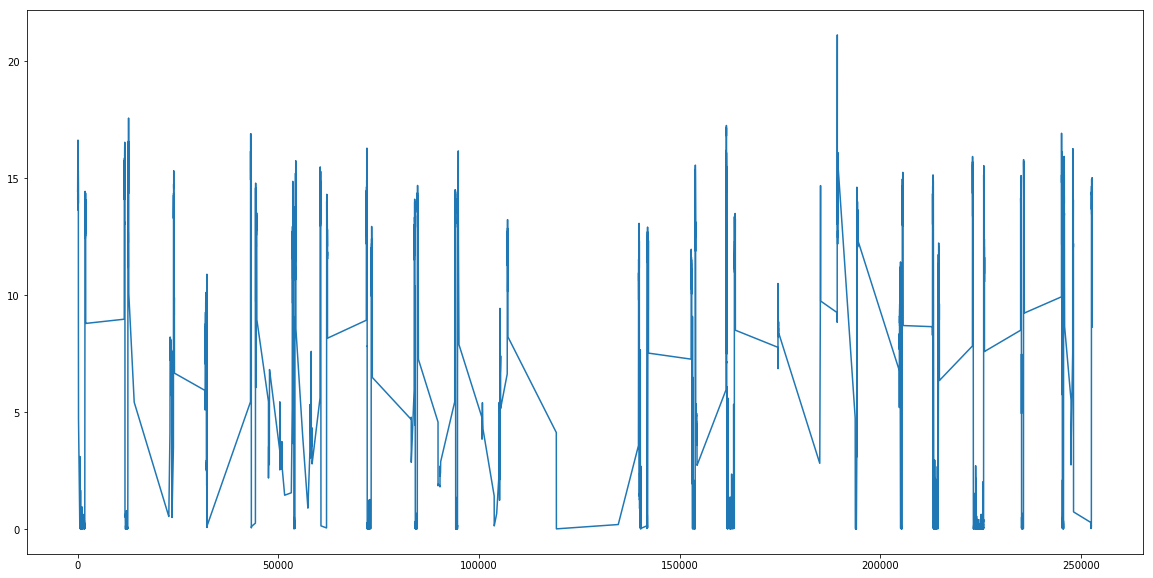

In [29]:
tmp.velocity.plot(figsize=fsize)

In [30]:
pois, (q_low, qhigh) = gspp.detect_POIs(tmp, alpha=20, window=100)

ValueError: too many values to unpack (expected 2)

In [70]:
diff_series = tmp.velocity.rolling(100).mean().diff().rolling(100).mean()
#detect the outliers of the above series.
outlier_groups = gspp.get_outliers(diff_series.dropna(), alpha=20)

pois = [poi for poi in outlier_groups]

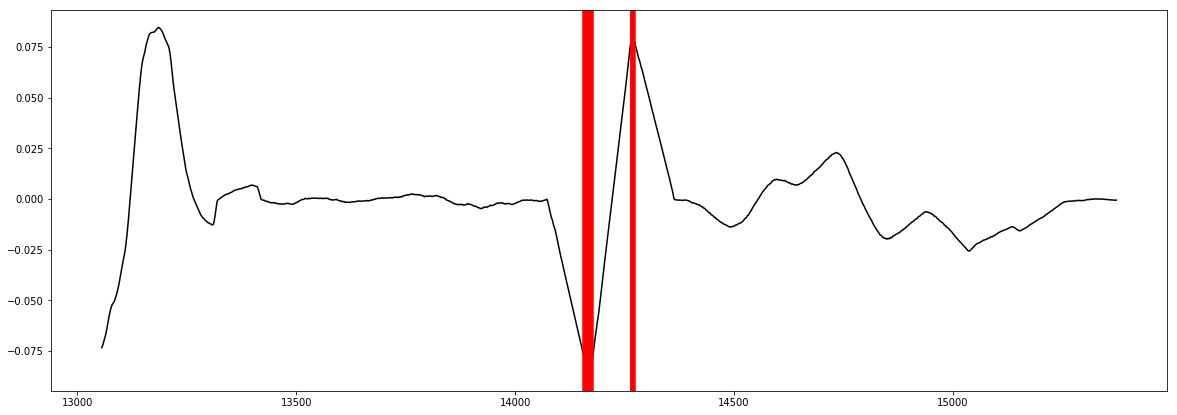

In [76]:
# plt.axvline(x=min(outs), c='r')
# plt.axvline(x=outs[0], c='r')
diff_series = tmp.velocity.rolling(100).mean().diff().rolling(100).mean()
diff_series[13056:15374].plot(figsize=(20,7), c='black')
# plt.axhline(y=q_high, c='g')
# plt.axhline(y=q_low, c='g')

# tmp[14056:14374].velocity.plot(figsize=(20,10), c=(0,0,0))
for poi in pois:
    if 14374>poi>14056:
        plt.axvline(x=poi, c='r')
    
    


# plt.savefig('poifig.png')
# gsplt.plot_segments(tmp, feature='slope',alpha=3)

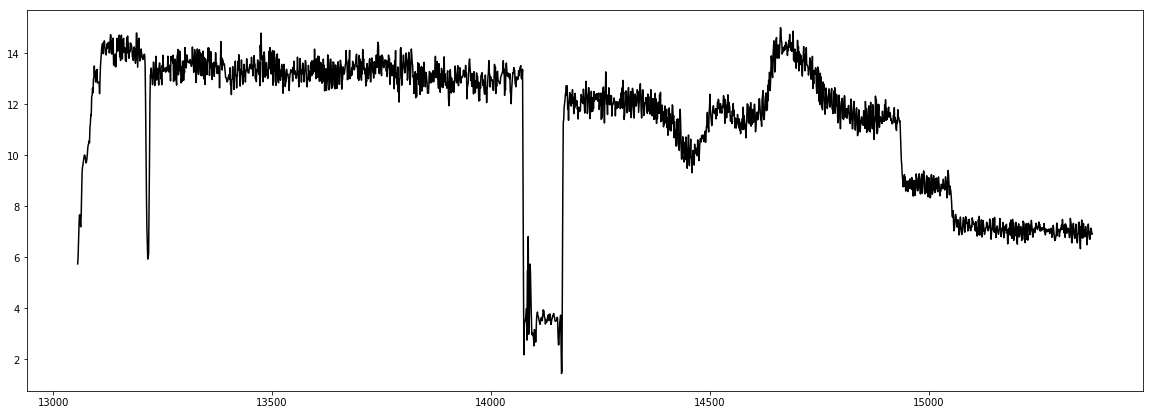

In [77]:
tmp[13056:15374].velocity.plot(figsize=(20,7), c=(0,0,0))

In [78]:
tmp[13056:15374]

,mmsi,turn,speed,course,heading,lon,lat,ts,geom,velocity
13056,226179000,-127.0,3.8,83.0,511,-4.321866,48.098736,1446738625,POINT (-4.3218665 48.098736),5.744712
13057,226179000,-127.0,4.3,83.8,511,-4.321325,48.098774,1446738644,POINT (-4.321325 48.098774),6.042078
13058,226179000,-127.0,4.7,86.0,511,-4.320705,48.098824,1446738665,POINT (-4.320705 48.098824),6.678595
13059,226179000,-127.0,5.0,74.2,511,-4.320362,48.098858,1446738675,POINT (-4.3203616 48.098858),7.243368
13060,226179000,-127.0,6.0,53.2,511,-4.320013,48.098965,1446738685,POINT (-4.3200135 48.098965),7.664814
13061,226179000,-127.0,6.6,28.6,511,-4.319726,48.099174,1446738695,POINT (-4.3197265 48.099174),7.665284
13062,226179000,-127.0,6.6,10.6,511,-4.319603,48.099460,1446738704,POINT (-4.3196034 48.09946),7.363221
13063,226179000,-127.0,7.2,24.2,511,-4.319433,48.099808,1446738716,POINT (-4.319433 48.099808),7.196679
13064,226179000,-127.0,7.3,23.1,511,-4.319284,48.100067,1446738725,POINT (-4.3192835 48.100067),7.634728
13065,226179000,-127.0,8.2,23.1,511,-4.319050,48.100400,1446738735,POINT (-4.31905 48.1004),8.475292


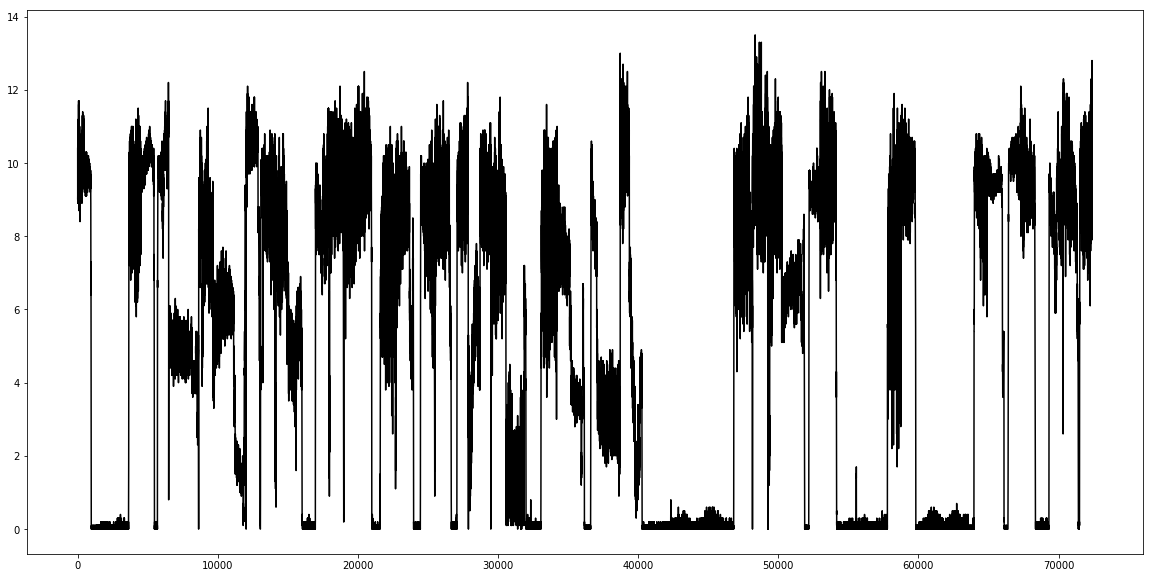

In [37]:
# plt.axvline(x=min(outs), c='r')
# plt.axvline(x=outs[0], c='r')
tmp.speed.plot(figsize=(20,10), c=(0,0,0))
# for poi in pois:
# #     if poi>5000: break
#     plt.axvline(x=poi, c='r')
    


# plt.savefig('poifig.png')
# gsplt.plot_segments(tmp, feature='slope',alpha=3)

In [12]:
(tmp.iloc[4999].ts - tmp.iloc[0].ts )/ (3600*24)

8.122800925925926

In [46]:
diffs = tmp[:5000]['velocity'].rolling(100).mean().diff().rolling(100).mean()

In [50]:
outlier_groups = gspp.get_outliers(diffs.dropna(), alpha=20)

In [51]:
for ind, point in enumerate(outlier_groups[1:],1):
    if point != outlier_groups[ind-1]+1:
        pois.append(point)

In [52]:
# for _, df in tqdm_notebook(traj.groupby('mmsi')):
pois

[0,
 199,
 489,
 11600,
 14056,
 22712,
 23859,
 31754,
 43072,
 44295,
 47550,
 51581,
 53238,
 55881,
 57376,
 60396,
 62016,
 71933,
 83103,
 89804,
 93959,
 100770,
 103800,
 104411,
 107049,
 119280,
 134711,
 141923,
 152874,
 161571,
 174515,
 184936,
 189278,
 193766,
 204765,
 213006,
 222984,
 234996,
 245180,
 247558,
 252566,
 252841]

In [9]:
for i in range(len(pois)-1):
    print(tmp.iloc[pois[i]].velocity - tmp.iloc[pois[i+1]].velocity)

13.351225314
-10.6627534594
1.64833855736


In [16]:
pois

[0, 242, 1468, 1709]

In [10]:
tmp.head()

,mmsi,turn,speed,course,heading,lon,lat,ts,geom,d2np,datetime,velocity
0,226179000.0,-127.0,9.700000,111.600000,511.0,-5.101860,48.229477,1.456863e+09,POINT (-5.10186 48.229477),0.220861,2016-03-01 20:02:00,13.399195
1,226179000.0,-127.0,9.250000,105.050000,511.0,-5.099131,48.228914,1.456863e+09,POINT (-5.09913085 48.2289135),0.219537,2016-03-01 20:03:00,13.399195
2,226179000.0,-127.0,8.800000,98.500000,511.0,-5.096402,48.228350,1.456863e+09,POINT (-5.0964017 48.22835),0.218214,2016-03-01 20:04:00,13.399195
3,226179000.0,-127.0,8.836364,99.845455,511.0,-5.092571,48.227519,1.456863e+09,POINT (-5.092571090909091 48.22751854545454),0.216760,2016-03-01 20:05:00,13.399195
4,226179000.0,-127.0,8.872727,101.190909,511.0,-5.088740,48.226687,1.456863e+09,POINT (-5.088740481818182 48.22668709090909),0.215306,2016-03-01 20:06:00,13.399195
